# TensorRT inference with torch2trt
![process diagram](./doc/torchvision-torch2trt.svg)

**Before you start this notebook, please shutdown other notebook kernels to allocate enough memory for this notebook.**  
<img src="./doc/kernel_shutdown.jpg" width="480">

## Prepare model and input image

Define a function to download a file.

In [1]:
import urllib
import os

def download_file(url, file=None):
    if file is None:
        file = os.path.basename(url)
    if os.path.exists(file):
        return file
    try:
        urllib.URLopener().retrieve(url, file)
    except:
        urllib.request.urlretrieve(url, file)
    return file

Specify a input image file.

In [2]:
image_file = 'bellpepper.jpg'
#image_file = download_file('https://github.com/pytorch/hub/raw/master/dog.jpg')
#image_file = download_file('https://upload.wikimedia.org/wikipedia/commons/b/b5/Canadian_Golden_Retriever.jpeg')

Download the ImageNet class file.

In [3]:
class_file = download_file('https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json')

Parse the class file and convert it to a Python dictionary.

In [4]:
import json
class_dict = json.load(open(class_file, 'r'))

Export the input image file to PyTorch tensor and normlize it in the ImageNet training image conditions.

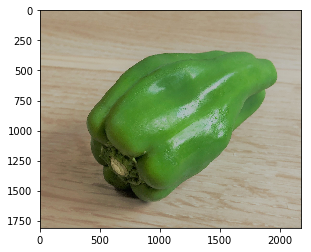

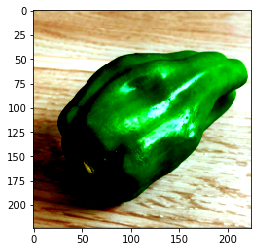

In [5]:
# sample execution (requires torchvision)
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

input_image = Image.open(image_file)
plt.imshow(input_image)
plt.show()

preprocess = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

filtered_image = input_tensor.clone()
filtered_image = filtered_image.numpy().transpose((1, 2, 0))
filtered_image = np.float32(filtered_image)
filtered_image = np.clip(filtered_image, 0, 1)
plt.imshow(filtered_image)
plt.show()

Download the Torchvision AlexNet pre-traind model.

In [6]:
from torchvision import models
net = models.alexnet(pretrained=True)
print(net)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

## Export the PyTorch model to TensorRT with torch2trt

In [7]:
import torch
from torch2trt import torch2trt

x = torch.zeros(1, 3, 224, 224).cuda()
model_trt = torch2trt(net.cuda(), [x])

## Do inference by TensorRT with torch2trt

In [8]:
y_trt = model_trt(input_batch.cuda()).cpu()
outputs = y_trt.numpy()
idxlist = np.argsort(outputs[0])[:-4:-1]
for i in idxlist:
    print('{}:\t{}'.format(class_dict[str(i)][1], outputs[0][i]))

bell_pepper:	15.869131088256836
cucumber:	13.745673179626465
Granny_Smith:	12.043103218078613


## Measure inference processing time

Define a decorator function to measure processing times.

In [9]:
import time
import functools

def processing_time(num_times, warmups=0):
    def _processing_time(func):
        @functools.wraps(func)
        def wrapper(*args, **kwargs):
            for i in range(warmups):
                ret = func(*args, **kwargs)
            t0 = time.time()
            for i in range(num_times):
                ret = func(*args, **kwargs)
            t1 = time.time()
            print('Average a {0} times trial: {1:,f}sec'.format(num_times, (t1 - t0) / num_times))
            return ret
        return wrapper
    return _processing_time

Define a test function with the pocessing time measurement decorator.

In [10]:
@processing_time(100, 10)
def test_inference(network, in_dat):
    out_dat = network(in_dat)
    return out_dat

Measure inference processing time.

In [11]:
image_cuda = input_batch.cuda()
torch.cuda.current_stream().synchronize()
y_trt = test_inference(model_trt, image_cuda).cpu()
torch.cuda.current_stream().synchronize()
outputs = y_trt.numpy()
idxlist = np.argsort(outputs[0])[:-4:-1]
for i in idxlist:
    print('{}:\t{}'.format(class_dict[str(i)][1], outputs[0][i]))

Average a 100 times trial: 0.015008sec
bell_pepper:	15.869131088256836
cucumber:	13.745673179626465
Granny_Smith:	12.043103218078613


Print the TensorRT network.

In [12]:
import trt_analyzer
import pandas as pd

net_dict = trt_analyzer.network_dict(model_trt.network)
pd.set_option('max_colwidth', 1000)
pd.DataFrame(net_dict)

,Name,Type,Inputs,Outputs,Type Specific Params
0,(Unnamed Layer* 0) [Convolution],LayerType.CONVOLUTION,"(3, 224, 224)","(64, 55, 55)","ksz=(11, 11) maps=64 stride=(4, 4) pad=(2, 2)"
1,(Unnamed Layer* 1) [Activation],LayerType.ACTIVATION,"(64, 55, 55)","(64, 55, 55)",type=ActivationType.RELU
2,(Unnamed Layer* 2) [Pooling],LayerType.POOLING,"(64, 55, 55)","(64, 27, 27)","type=PoolingType.MAX wsize=(3, 3) stride=(2, 2) pad=(0, 0)"
3,(Unnamed Layer* 3) [Convolution],LayerType.CONVOLUTION,"(64, 27, 27)","(192, 27, 27)","ksz=(5, 5) maps=192 stride=(1, 1) pad=(2, 2)"
4,(Unnamed Layer* 4) [Activation],LayerType.ACTIVATION,"(192, 27, 27)","(192, 27, 27)",type=ActivationType.RELU
5,(Unnamed Layer* 5) [Pooling],LayerType.POOLING,"(192, 27, 27)","(192, 13, 13)","type=PoolingType.MAX wsize=(3, 3) stride=(2, 2) pad=(0, 0)"
6,(Unnamed Layer* 6) [Convolution],LayerType.CONVOLUTION,"(192, 13, 13)","(384, 13, 13)","ksz=(3, 3) maps=384 stride=(1, 1) pad=(1, 1)"
7,(Unnamed Layer* 7) [Activation],LayerType.ACTIVATION,"(384, 13, 13)","(384, 13, 13)",type=ActivationType.RELU
8,(Unnamed Layer* 8) [Convolution],LayerType.CONVOLUTION,"(384, 13, 13)","(256, 13, 13)","ksz=(3, 3) maps=256 stride=(1, 1) pad=(1, 1)"
9,(Unnamed Layer* 9) [Activation],LayerType.ACTIVATION,"(256, 13, 13)","(256, 13, 13)",type=ActivationType.RELU


Display a diagram of the TensorRT network.

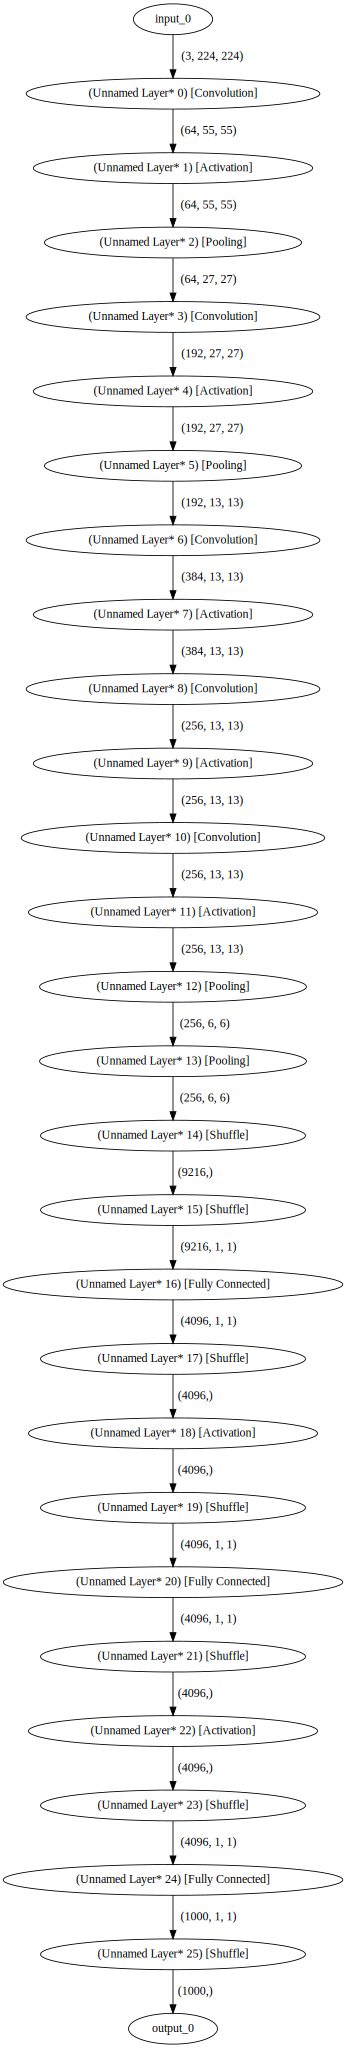

In [13]:
from torch2trt.utils import trt_network_to_dot_graph

dot = trt_network_to_dot_graph(model_trt.network)
dot

Save the TensorRT model.  
**Jetson Nano may fail this process for lack of memory.**

In [14]:
model_file_path = 'model_torch2trt.pth'
torch.save(model_trt.state_dict(), model_file_path)

Load the saved TensorRT model and do inference with it.  
**Jetson Nano may fail this process for lack of memory.**

In [15]:
from torch2trt import TRTModule

model_trt = TRTModule()
model_trt.load_state_dict(torch.load(model_file_path))

y_trt = model_trt(input_batch.cuda()).cpu()
outputs = y_trt.numpy()
idxlist = np.argsort(outputs[0])[:-4:-1]
for i in idxlist:
    print('{}:\t{}'.format(class_dict[str(i)][1], outputs[0][i]))

bell_pepper:	15.869131088256836
cucumber:	13.745673179626465
Granny_Smith:	12.043103218078613


## Work with custom layer

Import the pooling custom layer handling modules

In [16]:
import sys

cur_path = %pwd
plugin_path = os.path.join(cur_path, 'plugin')
sys.path.append(plugin_path)
from trt_plugin_pb2 import copy_Message
from trt_plugin_pb2 import pooling_Message
import trt_plugin_pb2

Load the pooling custom layer plugin.

In [17]:
import ctypes

lib_file = os.path.join(plugin_path, 'build', 'libPoolingPlugin.so')
lib = ctypes.CDLL(lib_file)

Get the plugin registry.

In [18]:
import tensorrt as trt

registry = trt.get_plugin_registry()
print([c.name for c in registry.plugin_creator_list])
print([c.plugin_namespace for c in registry.plugin_creator_list])

['RnRes2Br2bBr2c_TRT', 'RnRes2Br2bBr2c_TRT', 'RnRes2Br1Br2c_TRT', 'RnRes2Br1Br2c_TRT', 'CustomSkipLayerNormPluginDynamic', 'CustomEmbLayerNormPluginDynamic', 'CustomGeluPluginDynamic', 'CustomQKVToContextPluginDynamic', 'CustomFCPluginDynamic', 'SingleStepLSTMPlugin', 'interpolate', 'interpolate', 'pooling', 'copy']
['', '', '', '', '', '', '', '', '', '', 'torch2trt', 'torch2trt', 'macnica_trt_plugins', 'macnica_trt_plugins']


Register the plugin creator.

In [19]:
namespace = 'macnica_trt_plugins'
macnica_creators = [c for c in registry.plugin_creator_list if c.plugin_namespace == namespace]
for c in macnica_creators:
    registry.register_creator(c, namespace)

Define a plugin converter.

In [20]:
from torch2trt.torch2trt import *

@tensorrt_converter('torch.nn.functional.max_pool2d')
def convert_max_pool2d_plugin(ctx):
    # parse args
    input = get_arg(ctx, 'input', pos=0, default=None)
    kernel_size = get_arg(ctx, 'kernel_size', pos=1, default=None)
    stride = get_arg(ctx, 'stride', pos=2, default=None)
    padding = get_arg(ctx, 'padding', pos=3, default=0)
    dilation = get_arg(ctx, 'dilation', pos=4, default=1)
    ceil_mode = get_arg(ctx, 'ceil_mode', pos=5, default=False)
    
    # get input trt tensor (or create constant if it doesn't exist)
    input_trt = trt_(ctx.network, input)
    
    output = ctx.method_return

    # get kernel size
    if not isinstance(kernel_size, tuple):
        kernel_size = (kernel_size, ) * 2

    # get stride
    if not isinstance(stride, tuple):
        stride = (stride, ) * 2

    # get padding
    if not isinstance(padding, tuple):
        padding = (padding, ) * 2
    
    print('convert_max_pool2d_plugin:')
    print('input={}, kernel_size={}, stride={}, padding={}'.format( \
        input_trt.shape, kernel_size, stride, padding))
    
    registry = trt.get_plugin_registry()
    creator = registry.get_plugin_creator( \
        type='pooling', version='1', plugin_namespace='macnica_trt_plugins')
    
    sz = input_trt.shape
    if len(sz) == 3:
        sz = (1, sz[0], sz[1], sz[2])
    
    impl = trt_plugin_pb2.CUDA
    #impl = trt_plugin_pb2.CuDNN
    message = pooling_Message( \
        dims=sz, mode=trt_plugin_pb2.Maximum, window=kernel_size, stride=stride, impl=impl)
    plg = creator.deserialize_plugin('pooling', message.SerializeToString())
    layer = ctx.network.add_plugin_v2(inputs=[input_trt], plugin=plg)

    output._trt = layer.get_output(0)

Generate a TensorRT network with the plugin.

In [21]:
x = torch.zeros(1, 3, 224, 224).cuda()
model_trt = torch2trt(net.cuda(), [x])

convert_max_pool2d_plugin:
input=(64, 55, 55), kernel_size=(3, 3), stride=(2, 2), padding=(0, 0)
convert_max_pool2d_plugin:
input=(192, 27, 27), kernel_size=(3, 3), stride=(2, 2), padding=(0, 0)
convert_max_pool2d_plugin:
input=(256, 13, 13), kernel_size=(3, 3), stride=(2, 2), padding=(0, 0)


Print the TensorRT network.

In [22]:
net_dict = trt_analyzer.network_dict(model_trt.network)
pd.DataFrame(net_dict)

,Name,Type,Inputs,Outputs,Type Specific Params
0,(Unnamed Layer* 0) [Convolution],LayerType.CONVOLUTION,"(3, 224, 224)","(64, 55, 55)","ksz=(11, 11) maps=64 stride=(4, 4) pad=(2, 2)"
1,(Unnamed Layer* 1) [Activation],LayerType.ACTIVATION,"(64, 55, 55)","(64, 55, 55)",type=ActivationType.RELU
2,(Unnamed Layer* 2) [PluginV2Ext],LayerType.PLUGIN_V2,"(64, 55, 55)","(64, 27, 27)",
3,(Unnamed Layer* 3) [Convolution],LayerType.CONVOLUTION,"(64, 27, 27)","(192, 27, 27)","ksz=(5, 5) maps=192 stride=(1, 1) pad=(2, 2)"
4,(Unnamed Layer* 4) [Activation],LayerType.ACTIVATION,"(192, 27, 27)","(192, 27, 27)",type=ActivationType.RELU
5,(Unnamed Layer* 5) [PluginV2Ext],LayerType.PLUGIN_V2,"(192, 27, 27)","(192, 13, 13)",
6,(Unnamed Layer* 6) [Convolution],LayerType.CONVOLUTION,"(192, 13, 13)","(384, 13, 13)","ksz=(3, 3) maps=384 stride=(1, 1) pad=(1, 1)"
7,(Unnamed Layer* 7) [Activation],LayerType.ACTIVATION,"(384, 13, 13)","(384, 13, 13)",type=ActivationType.RELU
8,(Unnamed Layer* 8) [Convolution],LayerType.CONVOLUTION,"(384, 13, 13)","(256, 13, 13)","ksz=(3, 3) maps=256 stride=(1, 1) pad=(1, 1)"
9,(Unnamed Layer* 9) [Activation],LayerType.ACTIVATION,"(256, 13, 13)","(256, 13, 13)",type=ActivationType.RELU


Do inference by TensorRT with the generated network.

In [23]:
y_trt = model_trt(input_batch.cuda()).cpu()
outputs = y_trt.numpy()
idxlist = np.argsort(outputs[0])[:-4:-1]
for i in idxlist:
    print('{}:\t{}'.format(class_dict[str(i)][1], outputs[0][i]))

bell_pepper:	15.869131088256836
cucumber:	13.745674133300781
Granny_Smith:	12.043103218078613
